In [60]:
import pandas as pd
import os
import dateutil as du
import json
import random

def to_seconds(t):
    return int(du.parser.isoparse(t).timestamp())

pwd = "/home/jfreeman/52/part3"
os.chdir(pwd)

# Set different marker styles for each application
marker_styles = ["o-", "s-", "D-", "*-", "x-", "^-", "v-"]
random.shuffle(marker_styles)

# Set different colors for each application
colors = {
    "parsec-blackscholes": "#CCA000",
    "parsec-canneal": "#CCCCAA",
    "parsec-dedup": "#CCACCA",
    "parsec-ferret": "#AACCCA",
    "parsec-freqmine": "#0CCA00",
    "parsec-radix": "#00CCA0",
    "parsec-vips": "#CC0A00",
}

"""
\definecolor{blackscholes}{HTML}{CCA000}
\definecolor{canneal}{HTML}{CCCCAA}
\definecolor{dedup}{HTML}{CCACCA}
\definecolor{ferret}{HTML}{AACCCA}
\definecolor{freqmine}{HTML}{0CCA00}
\definecolor{radix}{HTML}{00CCA0}
\definecolor{vips}{HTML}{CC0A00}
"""


# list all file prefixes in ../parsec-benchmarks/part3
file_prefixes = [fname[:-len(".yaml")] for fname in os.listdir("../parsec-benchmarks/part3") if fname.endswith(".yaml")]
print(file_prefixes)

application_names = file_prefixes# fill in the policy for each application by looking at 
# 1. spec.containers.nodeSelector.cca-project-nodetype will be of the form node-<node>-<number of cores>cores. Extract the <node> (a letter)
# 2. spec.containers.args will be of the form ["-c", "taskset -c <core range> ... "]. Extract the core range.

# fill in the policy for each application by looking at items in the pods.json file
def get_policies(run:int):
    policies = {}
    path = f"../experiments/part3/run{run}/pods.json"
    with open(path) as f:
        data = json.load(f)
        for item in data["items"]:
            name = item["metadata"]["labels"]["name"] if "name" in item["metadata"]["labels"] else item["metadata"]["labels"]["job-name"]
            args = item["spec"]["containers"][0]["args"]
            # parse the core range from the args
            core_range = args[1].split(" ")[2]
            # parse the node type from the node selector
            node_type = item["spec"]["nodeSelector"]["cca-project-nodetype"]
            node:str = node_type.split("-")[1]
            s = "s" if "-" in core_range else ""
            policies[name] = f"Core{s} {core_range} ({node.capitalize()})"

    return policies

assert get_policies(1) == get_policies(2) == get_policies(3), "Policies are not consistent across runs"

policies = get_policies(1)
            
    

['parsec-radix', 'parsec-canneal', 'parsec-blackscholes', 'parsec-vips', 'parsec-dedup', 'parsec-ferret', 'parsec-freqmine']


In [61]:
    

start_end_pairs = {}
for i in range(1, 4):
    for app_name in application_names:
        path = f"../experiments/part3/run{i}/pods.json"
        with open(path, "r") as f:
            data = json.load(f)
            # only keep the data entries that have entry["status"]["containerStatuses"][0]["state"]["terminated"]
            data = [entry["status"]["containerStatuses"][0] for entry in data["items"] if "terminated" in entry["status"]["containerStatuses"][0]["state"]]
            
            # entry is the first element in data that has entry["state"]["name"] == appname
            entry = next(entry for entry in data if entry["name"] == app_name)
            start_time = to_seconds(entry["state"]["terminated"]["startedAt"])
            end_time = to_seconds(entry["state"]["terminated"]["finishedAt"])
            start_end_pairs[(i, app_name)] = (start_time, end_time)

print(f"The following is the start and end times for each application of each run: \n{start_end_pairs}")           
            
# calculate the average and std makespan for each application
makespans = {}
for app_name in application_names:
    makespans[app_name] = []
    for i in range(1, 4):
        start_time, end_time = start_end_pairs[(i, app_name)]
        makespan = end_time - start_time
        makespans[app_name].append(makespan)

    makespans[app_name] = (sum(makespans[app_name]) / 3, pd.Series(makespans[app_name]).std())

# calculate average and std makespan for total (earliest start time to latest end time)
makespans["total"] = []
for i in range(1, 4):
    start_time, end_time = start_end_pairs[(i, "parsec-blackscholes")]
    for app_name in application_names:
        start_time = min(start_time, start_end_pairs[(i, app_name)][0])
        end_time = max(end_time, start_end_pairs[(i, app_name)][1])
    makespan = end_time - start_time
    makespans["total"].append(makespan)

makespans["total"] = (sum(makespans["total"]) / 3, pd.Series(makespans["total"]).std())
print(f"The following is the average and std makespan for each application:")
print("\\begin{table}[ht]")
print("\t\\centering")
print("\t\\begin{tabular}{ |c|c|c|c|c|} ")
print("\t\t\\hline")
print("\t\tjob name & mean time [s] & std [s] \\\\ \\hline \\hline")
for app_name in application_names:
    mean, std = makespans[app_name]
    print(f"\t\t\\coloredcell{{{app_name}}} & ${mean}$ & {std} \\\\ \\hline")
mean, std = makespans["total"]
print(f"\t\t\\coloredcell{{total time}} & ${mean}$ & {std} \\\\ \\hline")
print("\t\\end{tabular}")
print("\\end{table}")


# all on one thread.
tt_path = f"../experiments/part3/mcperf_msmts.txt"
marker_styles = {app: style for app, style in zip(application_names, marker_styles)}

df = pd.read_csv(tt_path, delim_whitespace=True)
print(f"The following is the data frame for {tt_path}:")
df




The following is the start and end times for each application of each run: 
{(1, 'parsec-radix'): (1715519314, 1715519348), (1, 'parsec-canneal'): (1715519313, 1715519427), (1, 'parsec-blackscholes'): (1715519313, 1715519460), (1, 'parsec-vips'): (1715519312, 1715519398), (1, 'parsec-dedup'): (1715519353, 1715519380), (1, 'parsec-ferret'): (1715519312, 1715519442), (1, 'parsec-freqmine'): (1715519309, 1715519463), (2, 'parsec-radix'): (1715519474, 1715519507), (2, 'parsec-canneal'): (1715519474, 1715519591), (2, 'parsec-blackscholes'): (1715519476, 1715519619), (2, 'parsec-vips'): (1715519474, 1715519559), (2, 'parsec-dedup'): (1715519512, 1715519539), (2, 'parsec-ferret'): (1715519475, 1715519603), (2, 'parsec-freqmine'): (1715519471, 1715519625), (3, 'parsec-radix'): (1715520030, 1715520063), (3, 'parsec-canneal'): (1715520031, 1715520145), (3, 'parsec-blackscholes'): (1715520029, 1715520177), (3, 'parsec-vips'): (1715520029, 1715520114), (3, 'parsec-dedup'): (1715520069, 1715520096)

,#type,avg,std,min,p5,p10,p50,p67,p75,p80,p85,p90,p95,p99,p999,p9999,QPS,target,ts_start,ts_end
0,read,239.4,162.7,80.4,132.4,145.7,215.5,255.1,281.5,301.4,325.6,358.0,405.4,504.3,1301.6,7886.8,29953.4,30000,1715518652641,1715518662849
1,read,232.8,311.6,86.8,128.5,139.3,203.4,239.3,263.3,282.6,308.5,344.1,399.7,506.9,2286.7,14455.5,30008.1,30005,1715518664359,1715518674499
2,read,228.3,204.8,86.8,127.2,137.9,201.1,237.3,262.8,282.9,309.7,345.8,399.3,503.4,1541.7,8685.0,30071.3,30010,1715518676008,1715518686119
3,read,231.7,180.0,86.8,128.3,139.1,205.5,243.4,268.0,288.0,314.2,352.2,407.8,518.3,1586.9,7990.9,29950.2,30015,1715518687628,1715518697741
4,read,219.4,184.0,80.4,124.0,134.1,193.9,228.4,251.5,270.9,296.3,332.7,383.4,475.7,1502.7,8032.0,30020.1,30020,1715518699248,1715518709359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,read,232.8,338.6,80.4,125.0,136.1,202.6,240.4,265.0,284.5,310.2,347.1,405.0,518.9,2048.2,20002.1,30153.2,30110,1715520241592,1715520251707
100,read,219.9,150.2,80.4,123.7,134.1,196.7,232.0,254.9,273.5,298.0,334.6,391.0,480.3,1051.7,6704.5,30232.6,30115,1715520253215,1715520263327
101,read,227.6,259.9,80.4,125.0,135.5,199.8,235.9,259.8,277.7,302.3,339.0,397.0,498.7,1936.7,11952.4,30128.4,30120,1715520264834,1715520274952
102,read,211.1,163.4,80.4,121.6,131.5,188.0,220.8,242.5,261.0,285.1,319.0,372.3,456.8,883.6,7585.7,30097.4,30125,1715520276462,1715520286574


{'parsec-radix': 'x-', 'parsec-canneal': 'D-', 'parsec-blackscholes': '*-', 'parsec-vips': 'o-', 'parsec-dedup': '^-', 'parsec-ferret': 'v-', 'parsec-freqmine': 's-'}


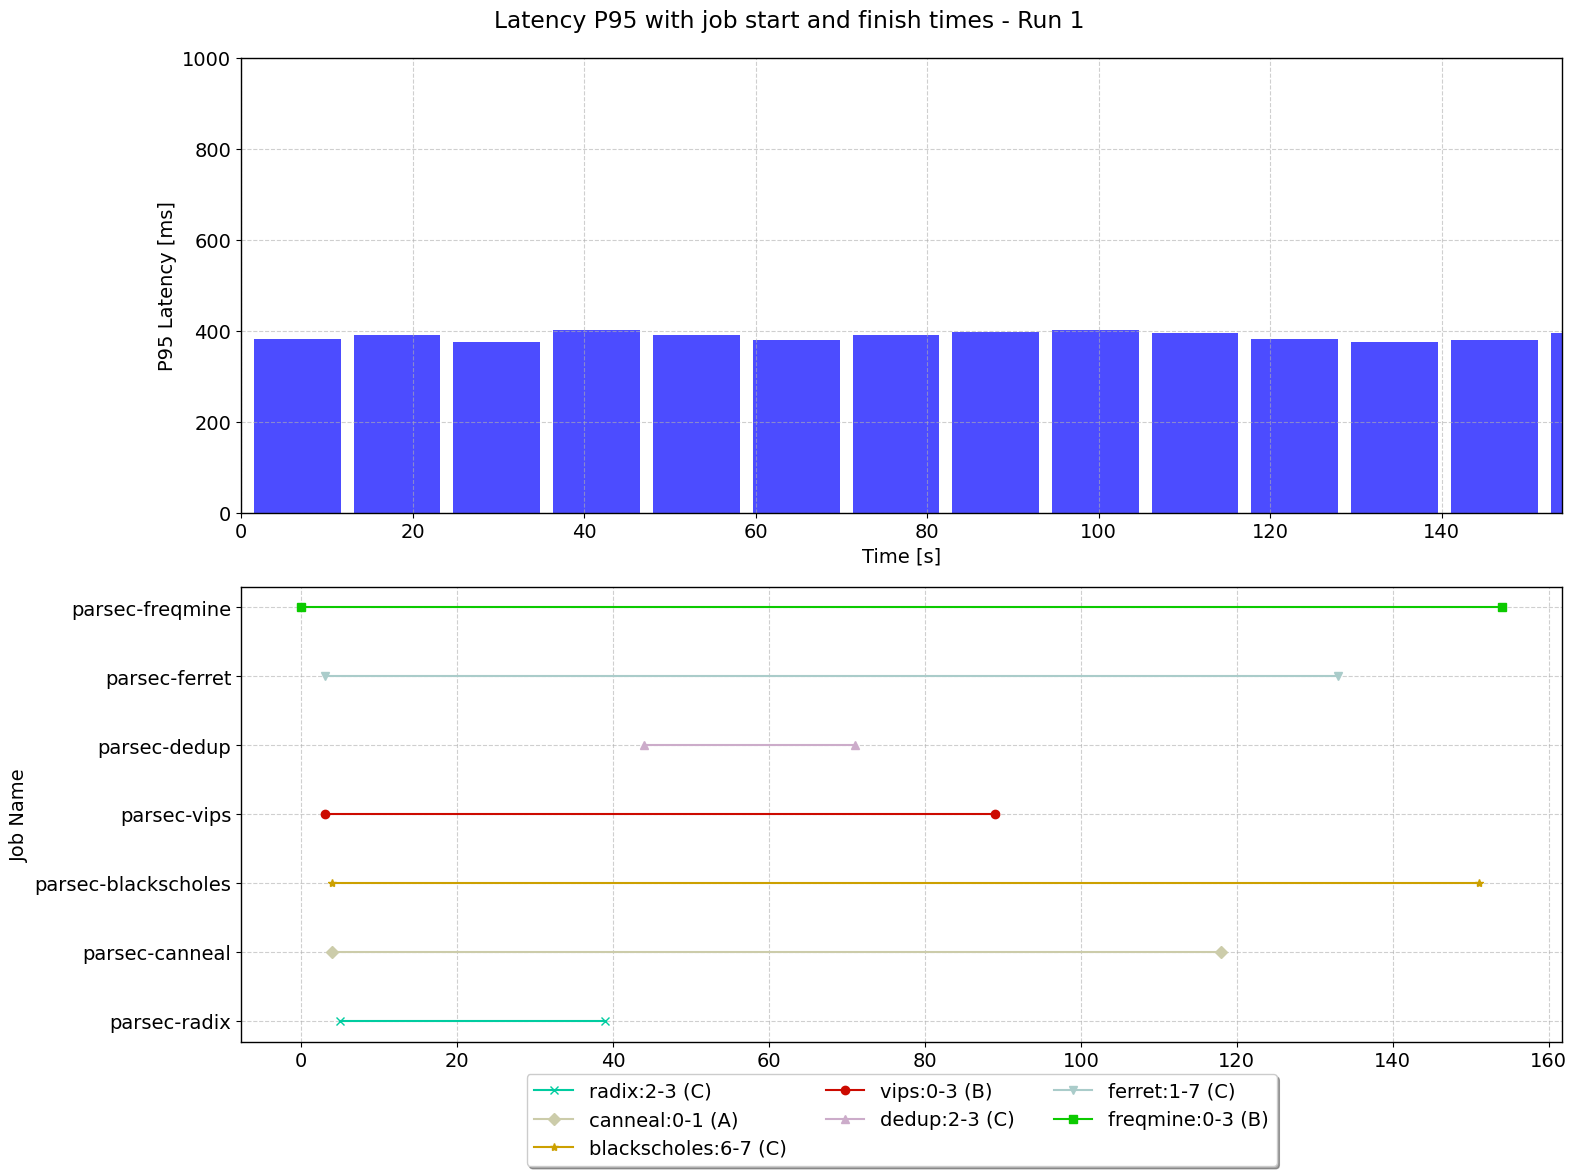

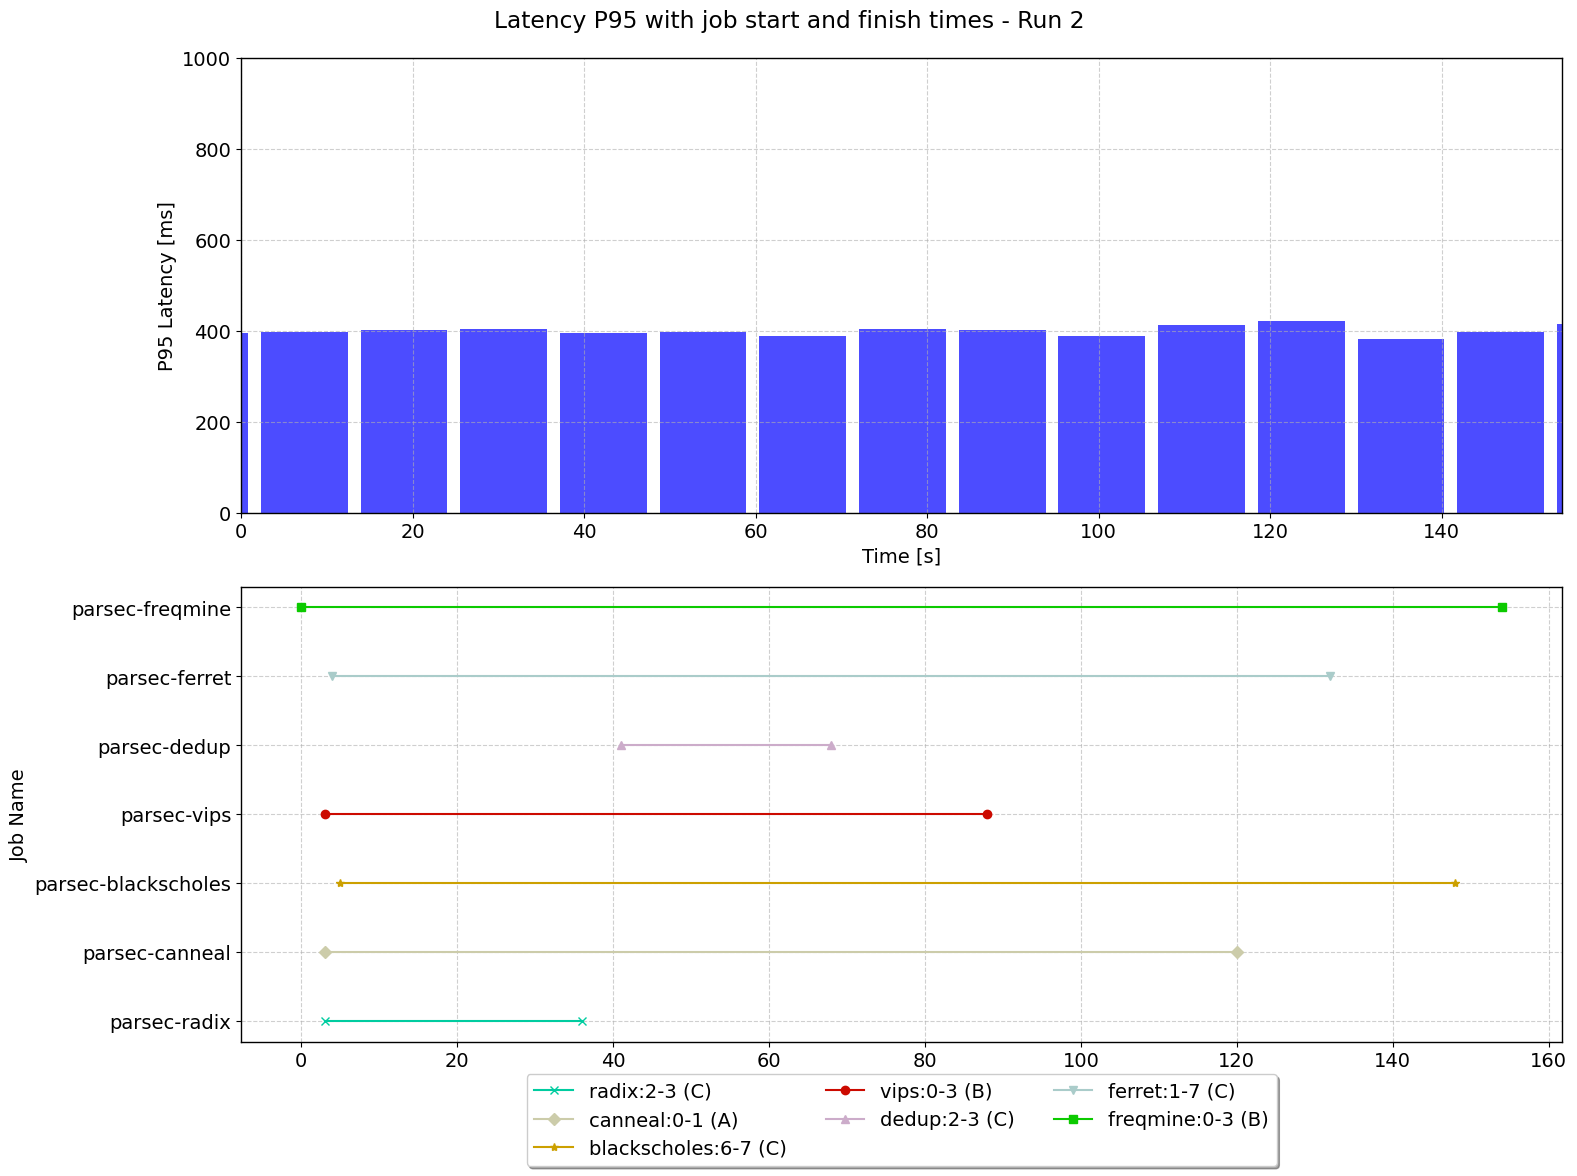

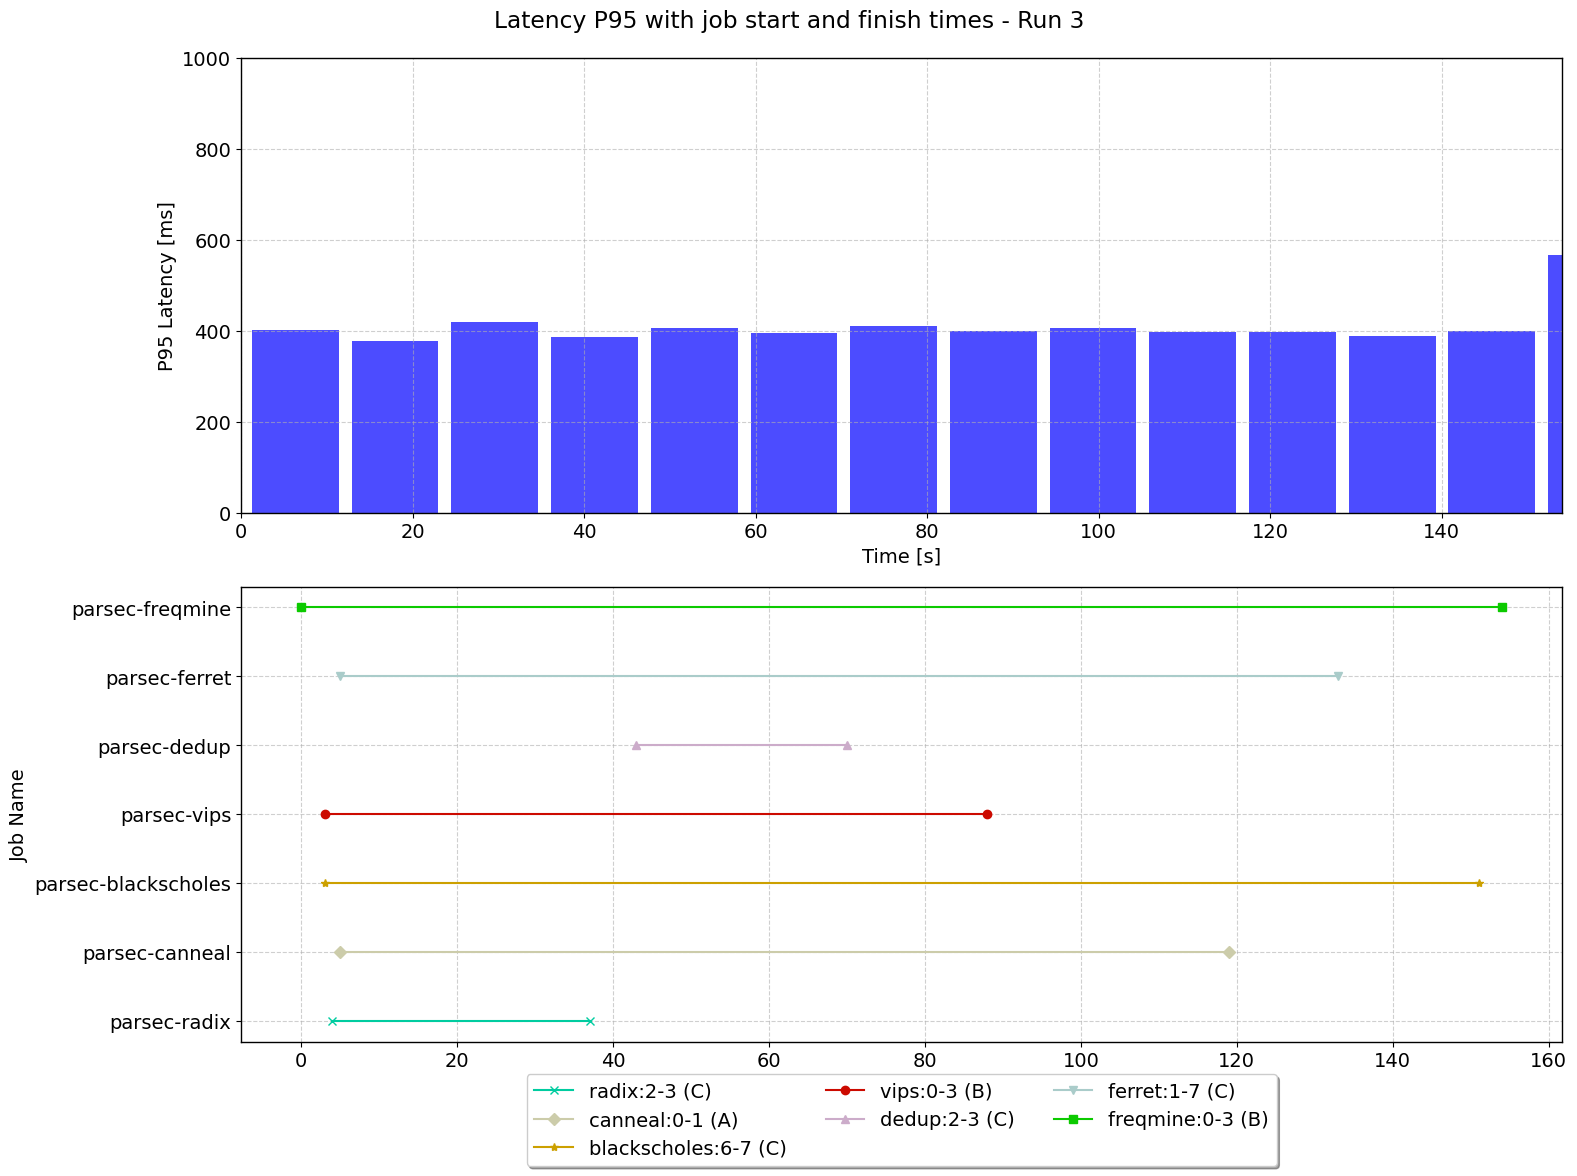

In [64]:
import matplotlib.pyplot as plt
import numpy as np
# make into a dictionary

print(marker_styles)
def create_plots(df, start_end_pairs, marker_styles, colors, policy):
    runs = [1, 2, 3]
    # set font size
    plt.rcParams.update({'font.size': 14})
    for run in runs:
        start_end_run = {k[1]: v for k, v in start_end_pairs.items() if k[0] == run}
        earliest_start = np.min([v[0] for v in start_end_run.values()])
        latest_end = np.max([v[1] for v in start_end_run.values()])

        fig, axs = plt.subplots(2, figsize=(16,12))
        fig.suptitle(f'Latency P95 with job start and finish times - Run {run}')

        for app, times in start_end_run.items():
            start = (times[0] - earliest_start)
            end = (times[1] - earliest_start)

            y = app
            app:str = app
            appname = app[len("parsec-"):]
            axs[1].plot([start, end], [y, y], marker_styles[app], color=colors[app], label=f"{appname}:{policy[app]}")

        axs[1].set_xlabel('Time [s]')
        axs[1].set_ylabel('Job Name')

        axs[1].set_yticks(range(len(start_end_run.keys())))
        axs[1].set_yticklabels(start_end_run.keys())

        axs[1].grid(True, linestyle='--', alpha=0.6)
        axs[1].legend(loc='best')

        latencies = df['p95']
        start_times = (df['ts_start'] - earliest_start*1000) / 1000
        widths = (df['ts_end'] - df['ts_start']) / 1000

        axs[0].bar(start_times, latencies, width=widths, color='blue', alpha=0.7)
        axs[0].set_xlabel('Time [s]')
        axs[0].set_ylabel('P95 Latency [ms]')
        
        axs[0].grid(True, linestyle='--', alpha=0.6)
        axs[0].set_xlim([0, (latest_end - earliest_start)])
        axs[0].set_ylim([0, 1000])

        for ax in axs:
            for spine in ax.spines.values():
                spine.set_color('black')
                spine.set_linewidth(1)
        # make sure that the legend is not covering a line. If the plot is the second plot, move the legend down a bit
        # loc can be one of the following: 'upper center', 'upper right', 'upper left', 'lower left', 'lower right', 'lower center', 'center right', 'center left', 'center', 'best'
        # or a tuple of the form (x, y) where x and y are floats between 0 and 1
        # once best is chosen, it can be  shifted via bbox_to_anchor

        # put the legend outside the plot
        axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=3)


        plt.tight_layout()
        #export as a pdf
        plt.savefig(f'run{run}_latency_p95.pdf')

create_plots(df, start_end_pairs, marker_styles, colors, policies)